In [8]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [9]:
path_to_data = Path('jass_data')

In [10]:
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)

In [11]:
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
print(data.head())

   DA  DK  DQ  DJ  D10  D9  D8  D7  D6  HA  ...  CQ  CJ  C10  C9  C8  C7  C6  \
0   0   0   0   1    1   0   1   1   0   0  ...   1   0    0   0   1   0   0   
1   0   0   0   0    0   0   0   0   1   1  ...   0   1    0   0   0   1   0   
2   1   0   0   1    0   0   0   0   0   0  ...   1   0    0   0   0   1   1   
3   0   0   0   0    0   0   0   0   0   1  ...   0   0    1   1   0   0   0   
4   0   1   0   0    0   0   0   0   1   1  ...   0   1    0   0   0   0   0   

   FH   user  trump  
0   0  53248      6  
1   0   4613      5  
2   0  68780      6  
3   0  24555      5  
4   1   8392      4  

[5 rows x 39 columns]


In [12]:
data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
data.dtypes

DA           bool
DK           bool
DQ           bool
DJ           bool
D10          bool
D9           bool
D8           bool
D7           bool
D6           bool
HA           bool
HK           bool
HQ           bool
HJ           bool
H10          bool
H9           bool
H8           bool
H7           bool
H6           bool
SA           bool
SK           bool
SQ           bool
SJ           bool
S10          bool
S9           bool
S8           bool
S7           bool
S6           bool
CA           bool
CK           bool
CQ           bool
CJ           bool
C10          bool
C9           bool
C8           bool
C7           bool
C6           bool
FH           bool
user        int64
trump    category
dtype: object

In [13]:
data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS',
                                  4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})
# Remove rows where the 'trump' column has the value 'PUSH'
data = data[data['trump'] != 'PUSH']

data.describe()

,user
count,222271.000000
mean,32058.063639
std,28787.690786
min,0.000000
25%,0.000000
50%,29201.000000
75%,56520.000000
max,85907.000000


In [14]:
data['cards_count'] = data[cards].sum(axis=1)
valid_hands = data['cards_count'] == 9  

if valid_hands.all():
    print("All hands contain exactly 9 cards.")
else:
    print("There are hands that do not contain exactly 9 cards.")
    print(data[~valid_hands][['card_count'] + cards])

All hands contain exactly 9 cards.


In [15]:
def count_colors(data):
    colors = {}
    for color in 'DHSC':
        # Count all cards of the given suit (e.g., all Diamonds, Hearts, etc.)
        colors[color] = data[[f'{color}{rank}' for rank in ['A', 'K', 'Q', 'J', '10', '9', '8', '7', '6']]].sum(axis=1)
    return colors

In [16]:
feature_columns = cards + forehand

In [17]:
# Initialize lists to store feature names
feature_columns = []
specified_features = []

# Feature creation loop
for color in 'DHSC':
    # Jack and nine combination
    new_col = f'{color}_J9'
    data[new_col] = data[f'{color}J'] & data[f'{color}9']
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # A K Q combination
    new_col = f'{color}_AKQ'
    data[new_col] = data[f'{color}A'] & data[f'{color}K'] & data[f'{color}Q']
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # 6 7 8 combination
    new_col = f'{color}_678'
    data[new_col] = data[f'{color}6'] & data[f'{color}7'] & data[f'{color}8']
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # Jack and nine combination with 4 more cards
    new_col = f'{color}_J_and_4_more'
    has_jack = data[f'{color}J']
    color_count = count_colors(data)[color]
    data[new_col] = has_jack & (color_count >= 5)
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # 9, A, and at least 3 other cards in the same suit
    new_col = f'{color}_9A_and_3_more'
    has_nine = data[f'{color}9']
    has_ace = data[f'{color}A']
    data[new_col] = has_nine & has_ace & (color_count >= 5)
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # Jack, 9, and Ace in the same suit
    new_col = f'{color}_J9A'
    has_jack = data[f'{color}J']
    has_nine = data[f'{color}9']
    has_ace = data[f'{color}A']
    data[new_col] = has_jack & has_nine & has_ace
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # Jack, 9, and at least one other card in suit, plus two Aces in other suits
    new_col = f'{color}_J9_plus_card_and_2_other_aces'
    other_ranks = ['A', 'K', 'Q', '10', '8', '7', '6']
    other_cards_in_suit = data[[f'{color}{rank}' for rank in other_ranks]].any(axis=1)
    other_colors = [c for c in 'DHSC' if c != color]
    aces_in_other_suits = data[[f'{c}A' for c in other_colors]].sum(axis=1)
    has_two_aces_in_other_suits = aces_in_other_suits >= 2
    data[new_col] = has_jack & has_nine & other_cards_in_suit & has_two_aces_in_other_suits
    feature_columns.append(new_col)
    specified_features.append(new_col)

# Create a new column that is True if any of the specified features is True
data['any_specified_feature_true'] = data[specified_features].any(axis=1)



In [18]:
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,S_J9A,S_J9_plus_card_and_2_other_aces,C_J9,C_AKQ,C_678,C_J_and_4_more,C_9A_and_3_more,C_J9A,C_J9_plus_card_and_2_other_aces,any_specified_feature_true
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
5,False,False,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True


In [19]:
# Count unique user IDs
num_unique_users = data['user'].nunique()
print("Number of unique users:", num_unique_users)

Number of unique users: 3222


In [20]:
# Count occurrences of each user ID
user_counts = data['user'].value_counts()
print(user_counts)

user
0        59264
4035       871
19345      827
56019      822
26309      669
         ...  
61197        1
7821         1
83211        1
81855        1
82883        1
Name: count, Length: 3222, dtype: int64


count     3222.000000
mean        68.985413
std       1047.085722
min          1.000000
25%          2.000000
50%         11.000000
75%         59.000000
max      59264.000000
Name: count, dtype: float64


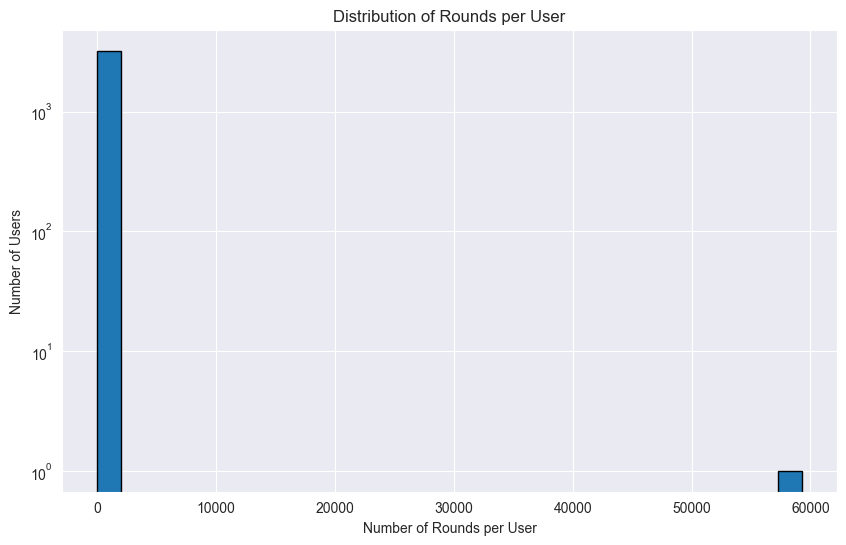

In [21]:
# Display basic statistics
print(user_counts.describe())

# Plot a histogram to visualize the distribution of rounds per user
plt.figure(figsize=(10, 6))
plt.hist(user_counts, bins=30, edgecolor='k', log=True)  # Using log scale for better visualization
plt.xlabel('Number of Rounds per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Rounds per User')
plt.show()


In [22]:
# Remove User 0 if determined to be a bot or outlier
filtered_data = data[data['user'] != 0]


In [23]:
filtered_data.describe()

,user,cards_count
count,163007.000000,163007.0
mean,43713.324354,9.0
std,24910.623019,0.0
min,1.000000,9.0
25%,17550.000000,9.0
50%,52246.000000,9.0
75%,61335.000000,9.0
max,85907.000000,9.0


count     3222.000000
mean        68.985413
std       1047.085722
min          1.000000
25%          2.000000
50%         11.000000
75%         59.000000
max      59264.000000
Name: count, dtype: float64


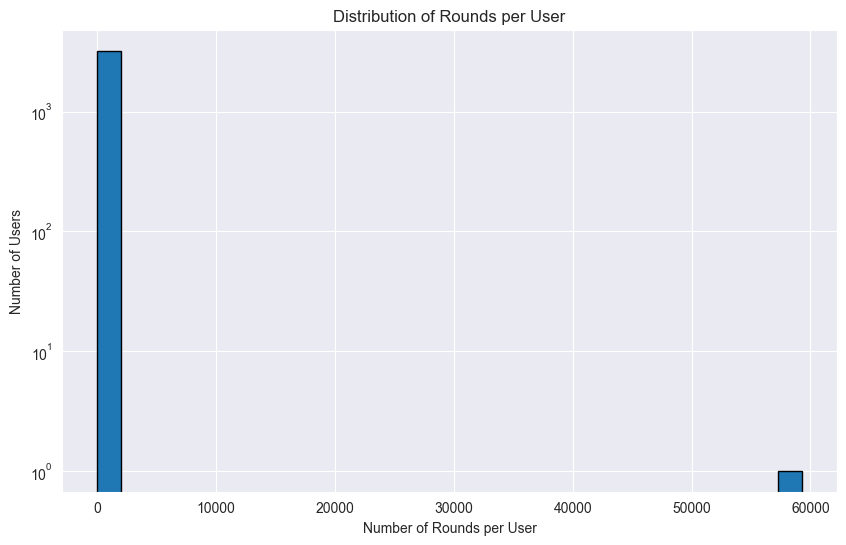

In [24]:
# Display basic statistics
print(user_counts.describe())

# Plot a histogram to visualize the distribution of rounds per user
plt.figure(figsize=(10, 6))
plt.hist(user_counts, bins=30, edgecolor='k', log=True)  # Using log scale for better visualization
plt.xlabel('Number of Rounds per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Rounds per User')
plt.show()

In [25]:
# Count occurrences of each user ID
user_counts = filtered_data['user'].value_counts()
print(user_counts)

user
4035     871
19345    827
56019    822
26309    669
331      619
        ... 
21406      1
52012      1
52177      1
29138      1
82820      1
Name: count, Length: 3221, dtype: int64


In [26]:
def check_bad_decision(row):
    bad_decision = 0
    # Check if player has any special feature
    for color in 'DHSC':
        # Rule for J9 and J_and_4_more: Trump should match the suit
        if row[f'{color}_J9'] and row['trump'] != color:
            bad_decision += 1
        if row[f'{color}_J_and_4_more'] and row['trump'] != color:
            bad_decision += 1

        # Rule for AKQ: Trump can be the same suit or OBE_ABE
        if row[f'{color}_AKQ'] and row['trump'] not in [color, 'OBE_ABE']:
            bad_decision += 1

    # Rule for 678: Trump should be UNE_UFE
    if (row['D_678'] or row['H_678'] or row['S_678'] or row['C_678']) and row['trump'] != 'UNE_UFE':
        bad_decision += 1

    # Return 1 if it's a bad decision (incorrect trump choice) for this round, else 0
    return bad_decision > 0

In [27]:
# Make a true copy of filtered_data if not already done
filtered_data = data[data['user'] != 0].copy()

# Now apply the bad decision function without triggering a warning
filtered_data['bad_decision'] = filtered_data.apply(check_bad_decision, axis=1)


In [28]:
filtered_data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,S_J9_plus_card_and_2_other_aces,C_J9,C_AKQ,C_678,C_J_and_4_more,C_9A_and_3_more,C_J9A,C_J9_plus_card_and_2_other_aces,any_specified_feature_true,bad_decision
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,False
5,False,False,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,False


In [29]:
# Define the threshold for bad player categorization (25% of rounds with special features)
bad_decision_threshold = 0.30

# Count the total number of bad decisions per user
bad_decision_counts = filtered_data.groupby('user')['bad_decision'].sum()

# Count the number of rounds with special features per user (rounds where `bad_decision` is evaluated)
special_feature_rounds = filtered_data.groupby('user')['bad_decision'].count()

# Calculate the percentage of bad decisions for each user
bad_decision_percentage = (bad_decision_counts / special_feature_rounds).fillna(0)

# Label users as bad if their percentage of bad decisions exceeds the threshold
user_labels = (bad_decision_percentage > bad_decision_threshold).astype(int)  # 1 for bad, 0 for good
user_labels = user_labels.rename("bad_player")

In [30]:
# Count the number of unique good and bad players
bad_player_counts = user_labels.value_counts()
print(bad_player_counts)

bad_player
1    1751
0    1470
Name: count, dtype: int64


In [31]:
# Filter to keep only good users (where 'bad_player' == 0)
good_users = user_labels[user_labels == 0].index  # Extract user IDs where 'bad_player' is 0


filtered_data = data[data['user'].isin(good_users)]


# Drop the 'bad_player' column if it exists, as we only want the data without bad user information
filtered_data = filtered_data.drop(columns=['bad_player', 'bad_decision', 'user', 'cards_count'], errors='ignore')


print(filtered_data)

           DA     DK     DQ     DJ    D10     D9     D8     D7     D6     HA  \
4       False   True  False  False  False  False  False  False   True   True   
11      False   True  False  False  False  False  False  False  False  False   
17      False  False   True  False  False  False  False  False  False  False   
34      False  False  False  False  False  False  False  False   True  False   
37      False  False  False  False   True  False  False  False  False  False   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
359778  False  False  False  False  False  False  False  False  False  False   
359780  False   True  False  False  False  False   True   True   True   True   
359802   True  False   True  False  False  False  False  False   True  False   
359812   True  False   True  False  False  False   True  False  False  False   
359822   True   True   True  False  False  False  False  False  False  False   

        ...  S_J9A  S_J9_plus_card_and_

In [32]:
# Save the DataFrame to a CSV file
filtered_data.to_csv('filtered_data.csv', index=False)
